In [83]:
# Load the required libraries
import pandas as pd 
import numpy as np

#viz
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image

from sklearn.model_selection import train_test_split

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from keras.preprocessing.text import text_to_word_sequence
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#settings
eng_stopwords = set(stopwords.words("english"))

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

### Let’s have a look at the data first and drop samples with missing comment_text.

In [84]:
data = pd.read_csv("CUTe_data.csv")
data.head()
print(data.isnull().sum())
print(len(data))

id             0
text           0
hate_speech    0
obscene        0
insulting      0
dtype: int64
31634


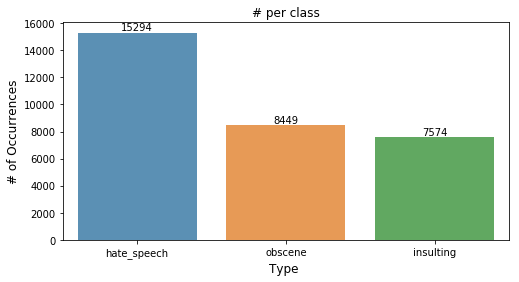

In [85]:
# Checking for the class imbalance

nrow_train=data.shape[0]

x=data.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()


350.41679838148826 599.2939788496886 5000


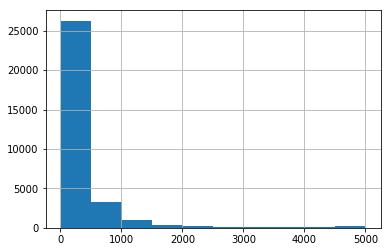

In [86]:
# Length of the sentence and the plot
lens = data.text.str.len()
print(lens.mean(), lens.std(), lens.max())
lens.hist();

In [87]:
label_cols = ['hate_speech', 'obscene', 'insulting']
data['constructive'] = 1-data[label_cols].max(axis=1)
data.describe()

,id,hate_speech,obscene,insulting,constructive
count,31634.000000,31634.000000,31634.000000,31634.000000,31634.000000
mean,15816.500000,0.483467,0.267086,0.239426,0.499083
std,9132.093544,0.499734,0.442445,0.426740,0.500007
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7908.250000,0.000000,0.000000,0.000000,0.000000
50%,15816.500000,0.000000,0.000000,0.000000,0.000000
75%,23724.750000,1.000000,1.000000,0.000000,1.000000
max,31633.000000,1.000000,1.000000,1.000000,1.000000


# WORD CLOUD

Lets dive into the words and see which words are more predominated in each class so that we could have good intution if any particular word is making a staright away helping to predict the class by just seeing the comments.

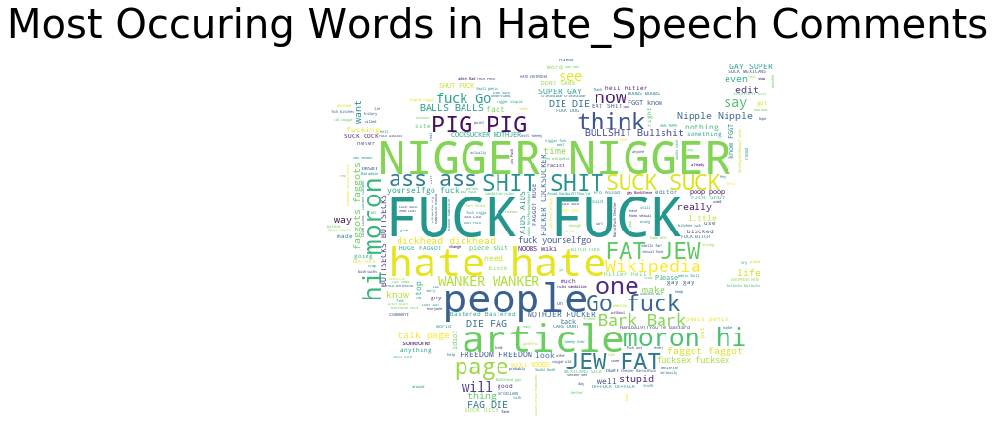

In [89]:
from wordcloud import WordCloud, ImageColorGenerator

wave_mask=np.array(Image.open('screenshot005.jpg'))

data1=data[data.hate_speech==1]
text=data1.text
wc= WordCloud(mask=wave_mask,background_color="white",max_words=1000)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))

plt.axis("off")
plt.title("Most Occuring Words in Hate_Speech Comments", fontsize=40)
plt.imshow(wc.recolor(random_state=17), alpha=0.98)
plt.show()

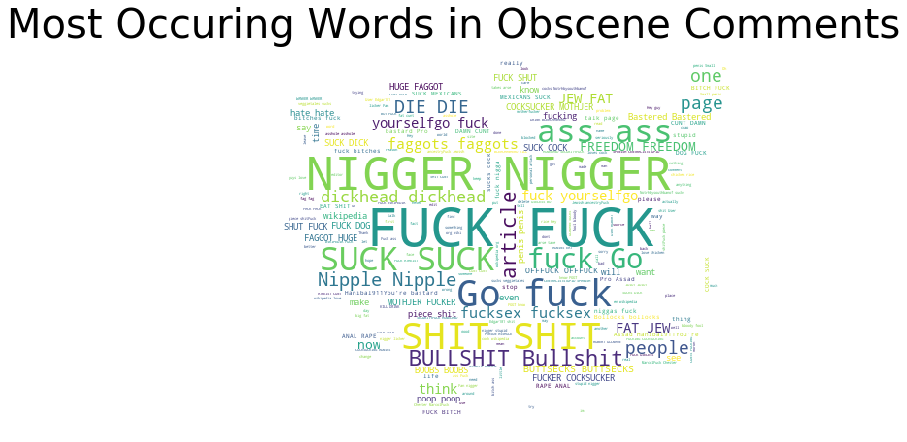

In [90]:
wave_mask=np.array(Image.open('screenshot005.jpg'))

data1=data[data.obscene==1]
text=data1.text
wc= WordCloud(mask=wave_mask,background_color="white",max_words=1000)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Most Occuring Words in Obscene Comments", fontsize=40)
plt.imshow(wc.recolor(random_state=17), alpha=0.98)
plt.show()

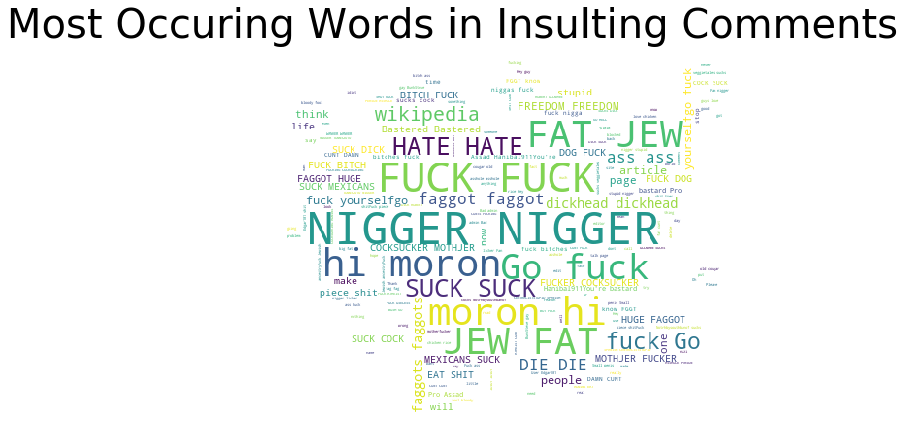

In [91]:

wave_mask=np.array(Image.open('screenshot005.jpg'))

data1=data[data.insulting==1]
text=data1.text
wc= WordCloud(mask=wave_mask,background_color="white",max_words=1000)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Most Occuring Words in Insulting Comments", fontsize=40)
plt.imshow(wc.recolor(random_state=17), alpha=0.98)

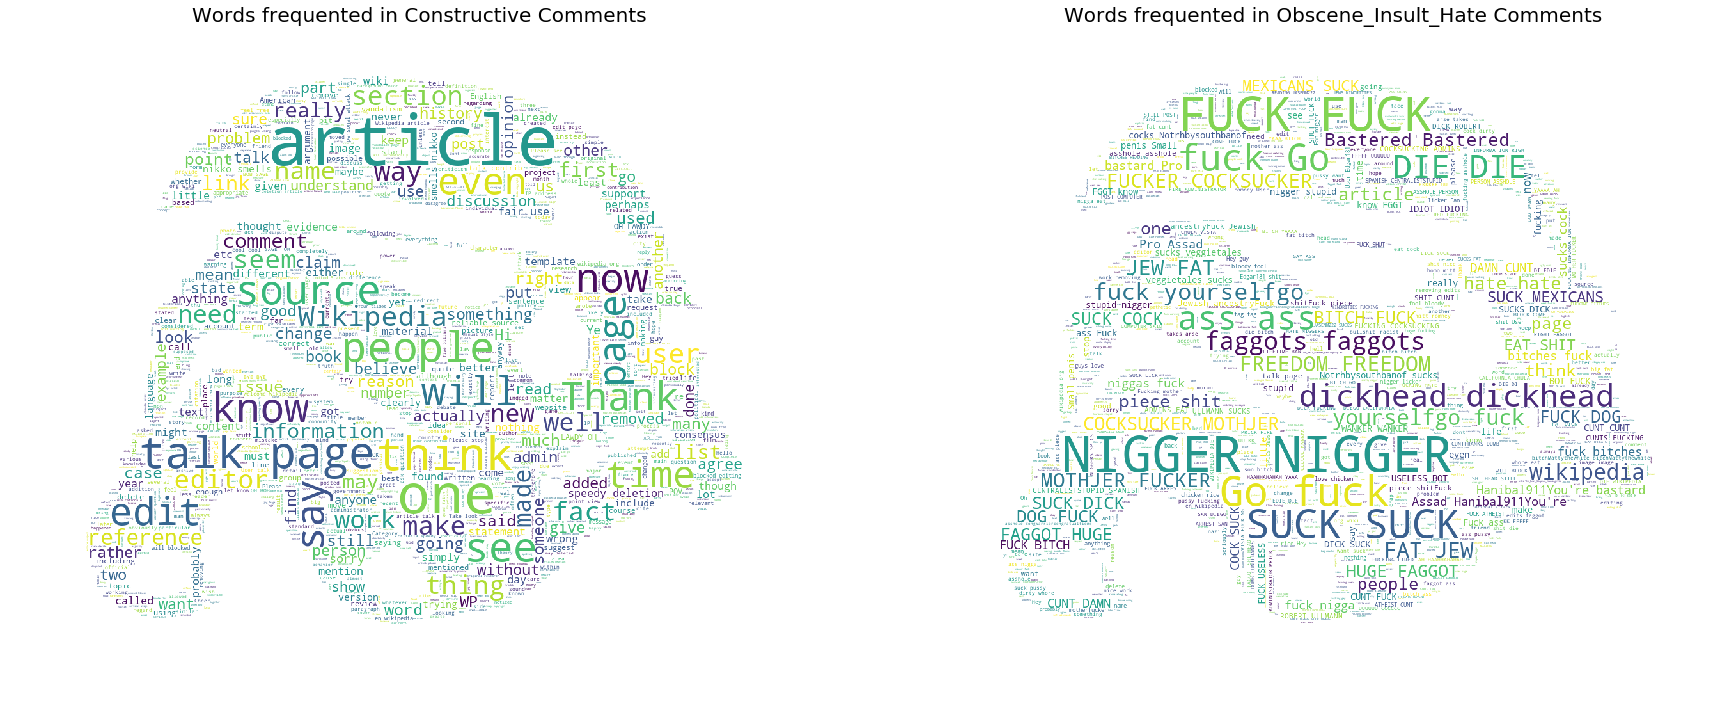

In [92]:
from wordcloud import WordCloud, ImageColorGenerator

plt.figure(figsize=(30,30))

data2=data[data['insulting']==0]
data2=data2[data2['obscene']==0]
data2=data2[data2['hate_speech']==0]

#wordcloud for clean comments
wave_mask=np.array(Image.open('abhi.png'))

text=data2.text
wc= WordCloud(mask=wave_mask,background_color="white",max_words=2000)
wc.generate(" ".join(text))
plt.subplot(1,2,1)
# image_colors = ImageColorGenerator(mask)
plt.axis("off")
plt.title("Words frequented in Constructive Comments", fontsize=20)
plt.imshow(wc.recolor(random_state=17), alpha=0.98)


data2=data[data['insulting']==1]
data2=data2[data2['obscene']==1]
data2=data2[data2['hate_speech']==1]

#wordcloud for clean comments
wave_mask=np.array(Image.open('abhi.png'))

text=data2.text
wc= WordCloud(mask=wave_mask,background_color="white",max_words=2000)
wc.generate(" ".join(text))
plt.subplot(1,2,2)
# image_colors = ImageColorGenerator(wavmask)
plt.axis("off")
plt.title("Words frequented in Obscene_Insult_Hate Comments", fontsize=20)
plt.imshow(wc.recolor(random_state=17), alpha=0.98)

# Adding up new features to look at the words features impact

In [93]:
data_features=data.copy()

In [94]:
## Indirect features
#Sentense count in each comment:
#  '\n' can be used to count the number of sentences in each comment
data_features['count_sent']=data_features["text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
data_features['count_word']=data_features["text"].apply(lambda x: len(str(x).split()))
#Unique word count
data_features['count_unique_word']=data_features["text"].apply(lambda x: len(set(str(x).split())))
#Letter count
data_features['count_letters']=data_features["text"].apply(lambda x: len(str(x)))
#punctuation count
data_features["count_punctuations"] =data_features["text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
data_features["count_words_upper"] = data_features["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
data_features["count_words_title"] = data_features["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
data_features["count_stopwords"] = data_features["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
data_features["mean_word_len"] = data_features["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [95]:
corelation=data_features.corr()
corelation=corelation.iloc[1:5,5:]
cols=corelation.columns
corelation

,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len
hate_speech,-0.013869,-0.084692,-0.180175,-0.089066,-0.013471,0.076358,-0.073963,-0.103925,0.006900
obscene,0.000854,-0.063100,-0.143884,-0.064098,-0.014312,0.061383,-0.056584,-0.083034,0.003227
insulting,-0.009624,-0.068208,-0.148829,-0.070682,-0.016740,0.059249,-0.063064,-0.084284,0.004580
constructive,0.008063,0.075856,0.167640,0.080784,0.009983,-0.075036,0.069080,0.093665,-0.007374


# Feature importance 

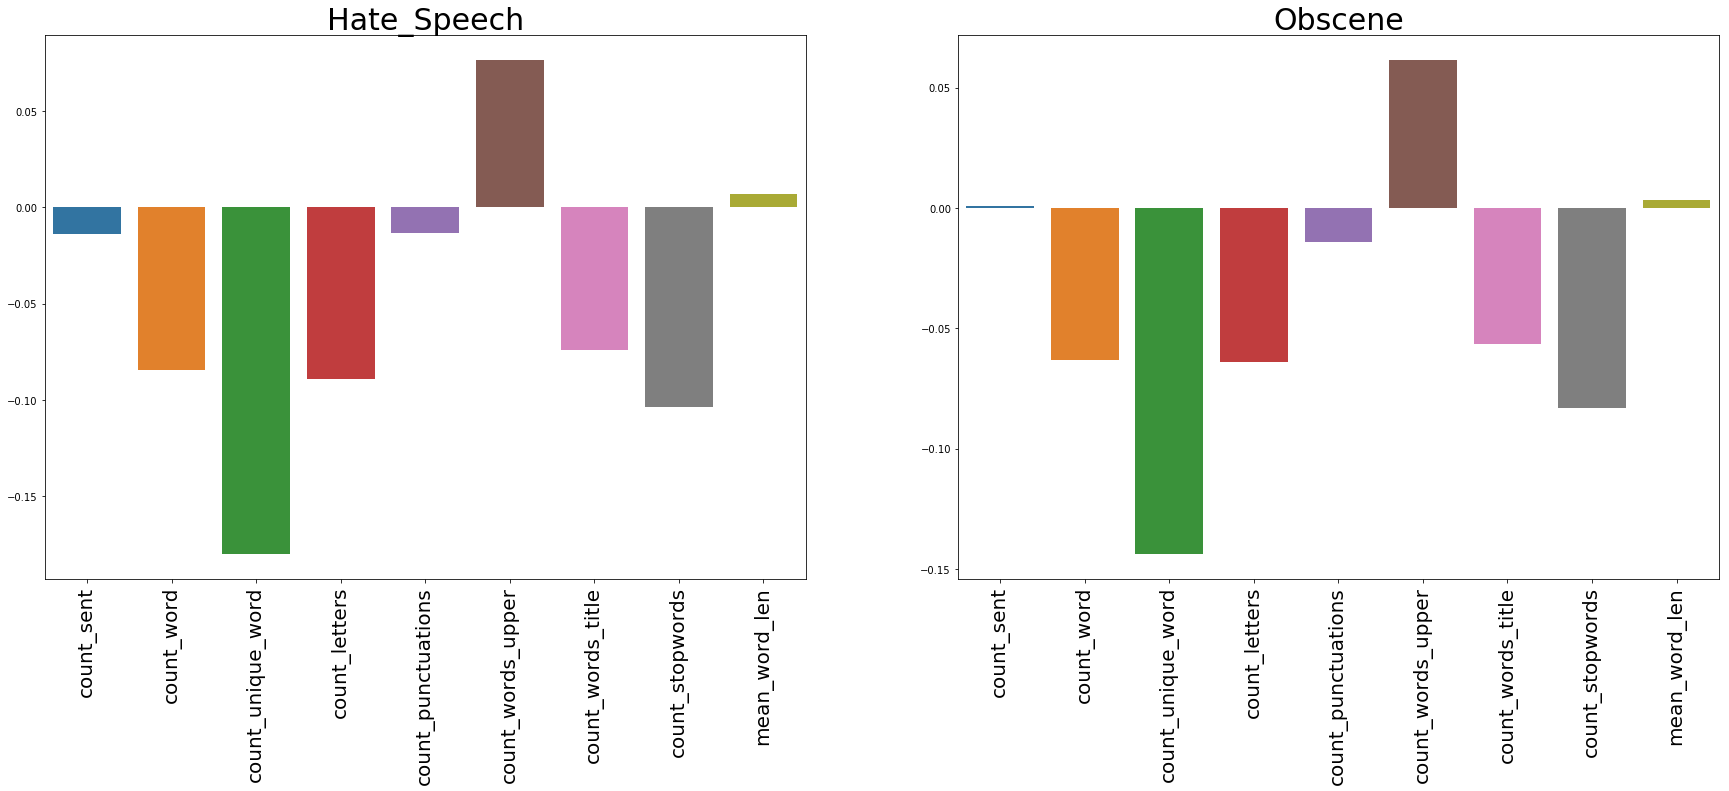

In [96]:
plt.figure(figsize=(30,10))

plt.subplot(1,2,1)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90,fontsize=20)
plt.title("Hate_Speech",fontsize=30)
sns.barplot(data=corelation.iloc[0:1,0:9])

plt.subplot(1,2,2)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90,fontsize=20)
plt.title("Obscene",fontsize=30)
sns.barplot(data=corelation.iloc[1:2,0:9])


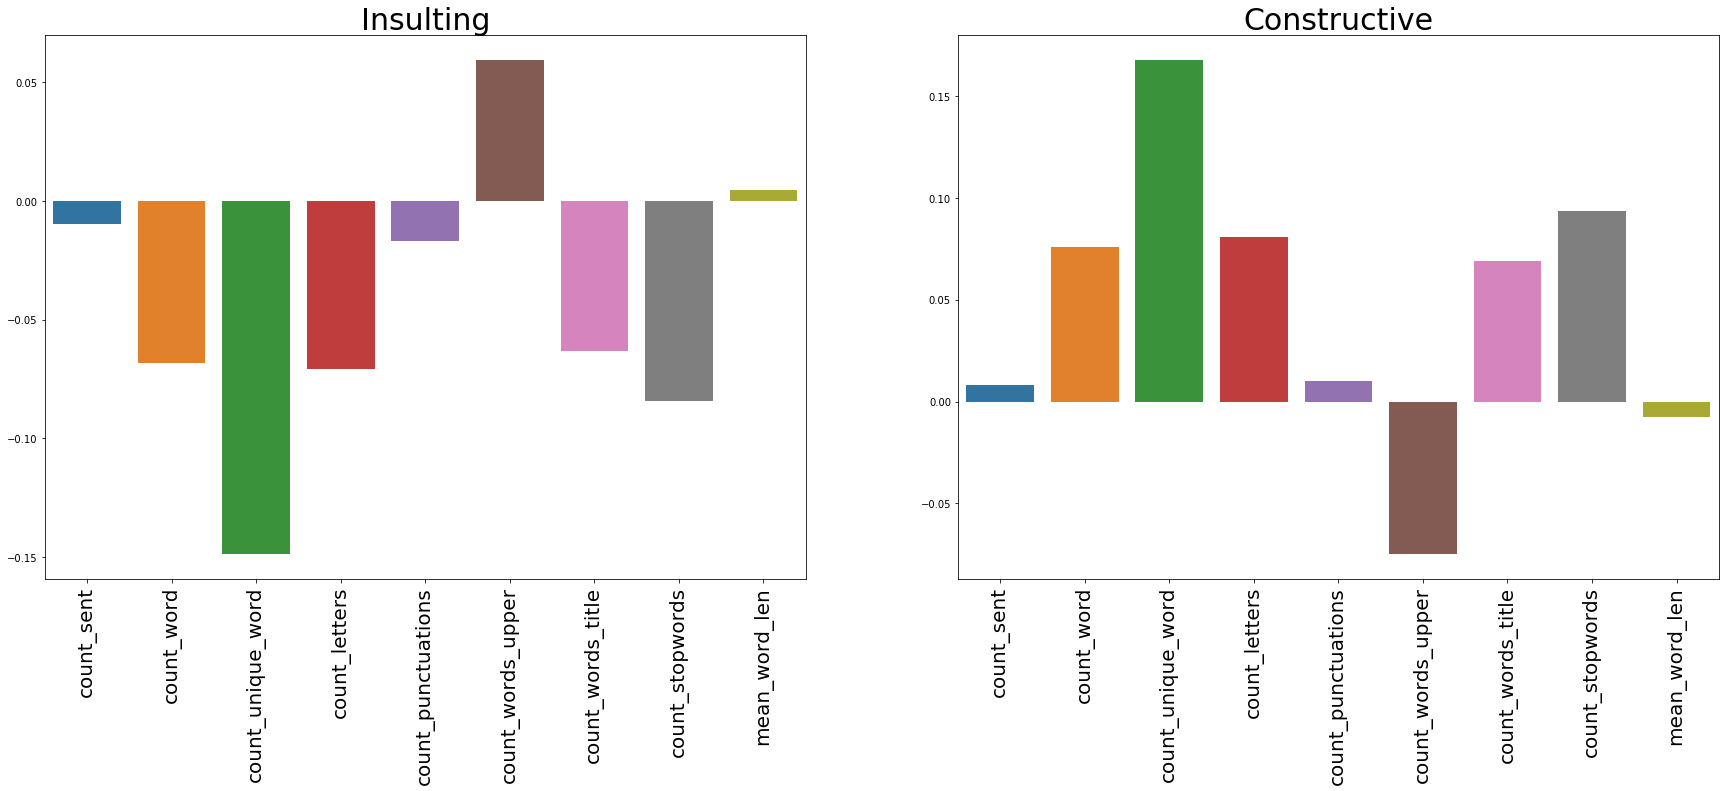

In [97]:
plt.figure(figsize=(30,10))

plt.subplot(1,2,1)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90,fontsize=20)
plt.title("Insulting",fontsize=30)
sns.barplot(data=corelation.iloc[2:3,0:9])

plt.subplot(1,2,2)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90,fontsize=20)
plt.title("Constructive",fontsize=30)
sns.barplot(data=corelation.iloc[3:4,0:9])

As we can see that the various features which were been extracted are not making any high corelation and we will be retaining few eatures out of them to see if it adds up any prediction accuracy to shoot up.

As we can see one more thing that if the comment is sapm then there is high chance of the comments to have more upper case letters and even the usage of unique words will be very less when compared to the constructive message.

# CLEANING THE TEXT WERE UNNECESSARY CHARACTERS ARE THERE SUCH AS SPECIAL CHARACTER SYMBOLS AND THE GRAMMER CHARACTERS

In [98]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [99]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [100]:
data_clean=data.copy()

In [101]:
data_clean['text']=data_clean['text'].apply(lambda x :clean(x))

In [102]:
## Indirect features
#Word count in each comment:
data_clean['count_word']=data_clean["text"].apply(lambda x: len(str(x).split()))
#Unique word count
data_clean['count_unique_word']=data_clean["text"].apply(lambda x: len(set(str(x).split())))
#Letter count
data_clean['count_letters']=data_clean["text"].apply(lambda x: len(str(x)))
#punctuation count
data_clean["count_punctuations"] =data_clean["text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#Average length of the words
data_clean["mean_word_len"] = data_clean["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [103]:
corelation=data_clean.corr()
corelation=corelation.iloc[1:5,5:]
cols=corelation.columns
corelation

,count_word,count_unique_word,count_letters,count_punctuations,mean_word_len
hate_speech,-0.066330,-0.180479,-0.078872,-0.063322,0.001579
obscene,-0.042563,-0.139356,-0.052413,-0.036598,0.004180
insulting,-0.050258,-0.145439,-0.060236,-0.047931,0.006419
constructive,0.059149,0.168345,0.071863,0.056755,-0.003029


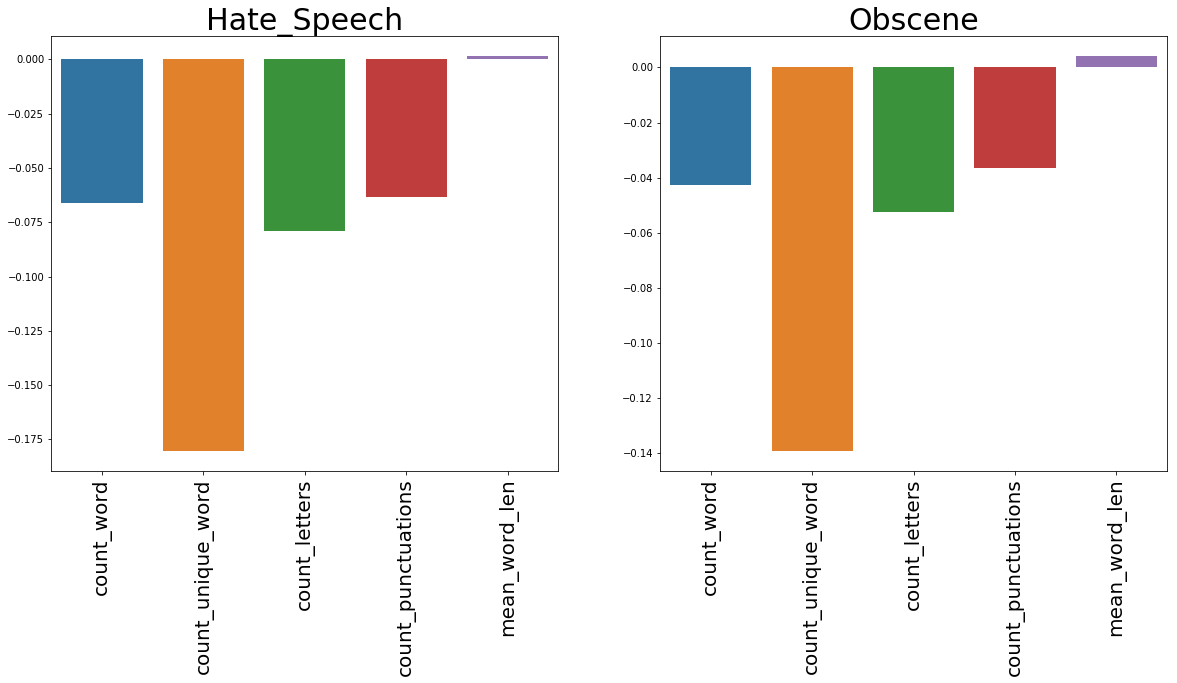

In [104]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90,fontsize=20)
plt.title("Hate_Speech",fontsize=30)
sns.barplot(data=corelation.iloc[0:1,0:9])

plt.subplot(1,2,2)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90,fontsize=20)
plt.title("Obscene",fontsize=30)
sns.barplot(data=corelation.iloc[1:2,0:9])



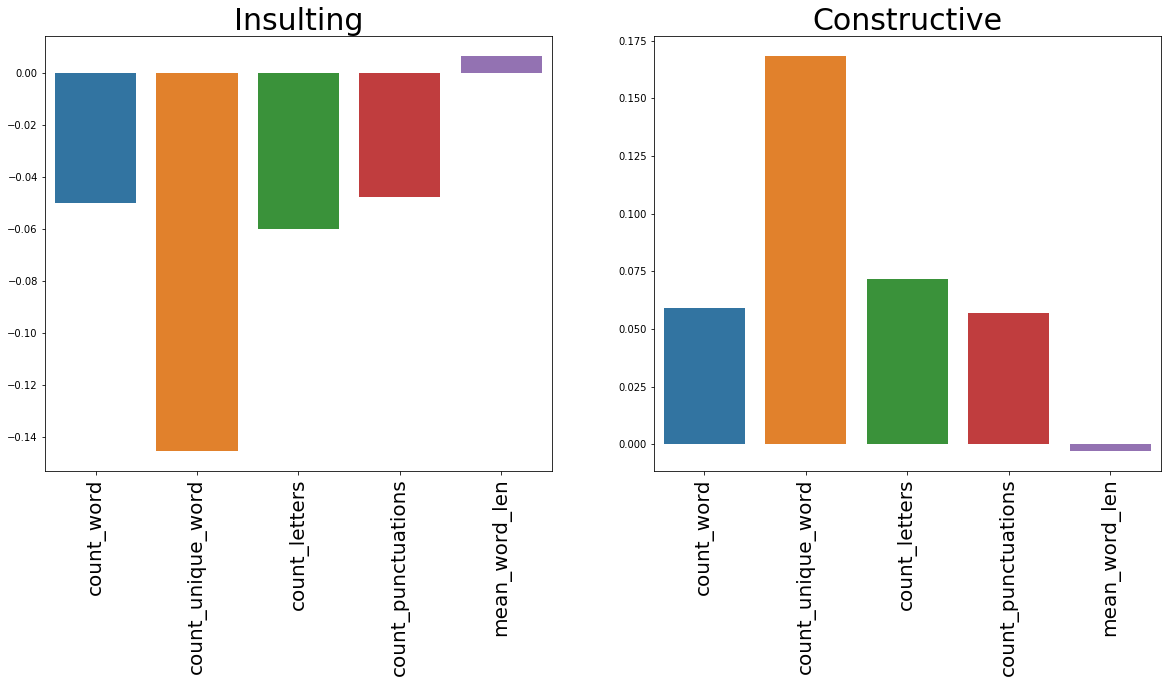

In [105]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90,fontsize=20)
plt.title("Insulting",fontsize=30)
sns.barplot(data=corelation.iloc[2:3,0:9])

plt.subplot(1,2,2)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90,fontsize=20)
plt.title("Constructive",fontsize=30)
sns.barplot(data=corelation.iloc[3:4,0:9])

## Till now initial text preprocessing and insight generation has been done and made three different data frames.

1. data (original data)
2. data_features (New features been added)
3. data_clean (after removing unnecessary characters from the text)

#### Split the Data into Train and test

In [106]:
X_features=data_features['text']
y_features=data_features.iloc[:,2:5]

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_features,y_features, test_size=0.20, random_state=42) # For Features Split and Raw Data

In [108]:
train_features=pd.DataFrame(X_train).join(y_train)
test_features=pd.DataFrame(X_test).join(y_test)

In [109]:
X_clean=data_clean['text']
y_clean=data_clean.iloc[:,2:5]

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_clean,y_clean, test_size=0.20, random_state=42) # For Features Split and Clean Data

In [111]:
train_clean=pd.DataFrame(X_train).join(y_train)
test_clean=pd.DataFrame(X_test).join(y_test)

In [112]:
#Let's see the words which constitutes the toxic comments
def getwordcountdf(data, key):
    filtered=data[data[key]==1]
    sequence=[]
    tr_words=set(stopwords.words('english'))
    for x in filtered.text:
        sequence+=text_to_word_sequence(x, 
                                        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                        lower=True,
                                        split=" ")
    filtered_words = [word for word in sequence if word not in tr_words]
    df= pd.DataFrame({'words': filtered_words})
    z= df.groupby('words').size().reset_index(name='counts')
    return z.sort_values('counts',ascending=False)

In [113]:
obscene=getwordcountdf(data, 'obscene')
insulting=getwordcountdf(data, 'insulting')
hate_speech=getwordcountdf(data,'hate_speech')

Text(0.5,1,'Hate')

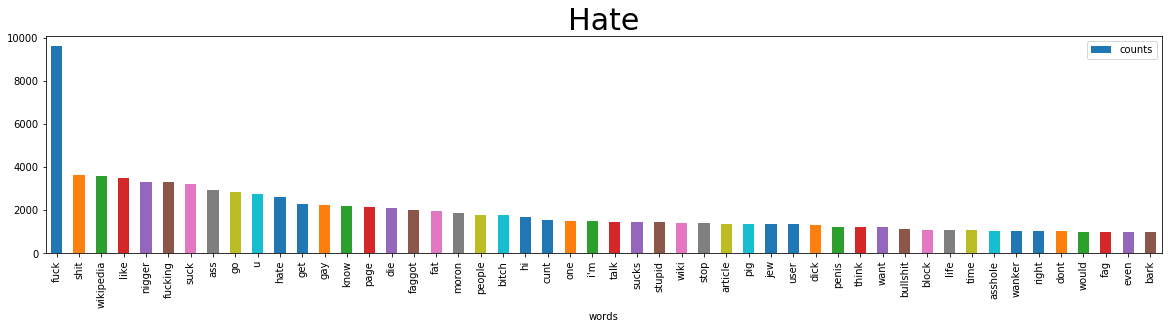

In [114]:
hate_speech.head(50).plot.bar(x='words', y='counts', figsize=(20,4))
plt.title('Hate',fontsize=30)

Text(0.5,1,'Obscene')

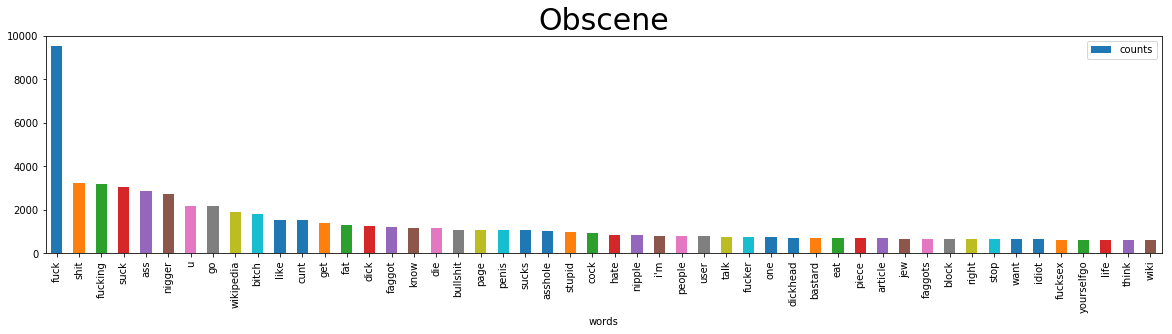

In [115]:
obscene.head(50).plot.bar(x='words', y='counts', figsize=(20,4))
plt.title('Obscene',fontsize=30)

Text(0.5,1,'Insulting')

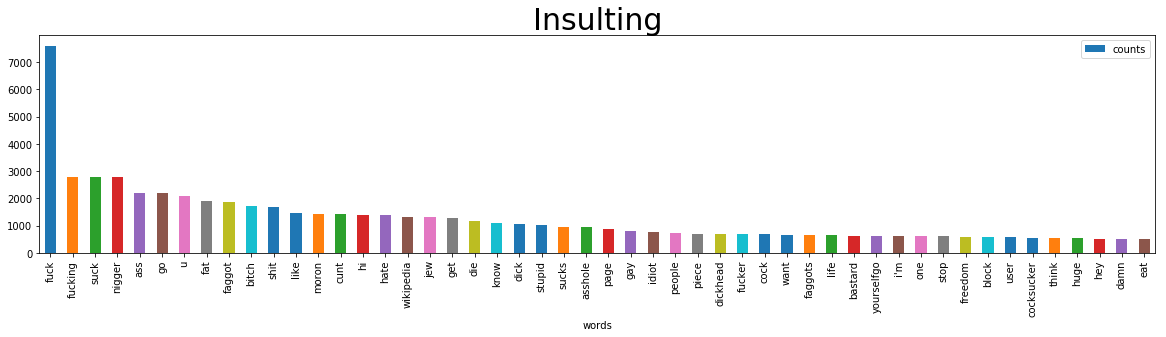

In [116]:
insulting.head(50).plot.bar(x='words', y='counts', figsize=(20,4))
plt.title('Insulting',fontsize=30)

# Model Building GRU

In [74]:
# Import the necessary libraries required to run the script coded below
import numpy as np
np.random.seed(42)
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,recall_score

from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['OMP_NUM_THREADS'] = '4'

In [79]:
# Predicting the weighted recall Defined function

from sklearn.metrics import recall_score # Metric to find the recall

def recall_test(testlabelslabels,preds):
    tar_clean=testlabelslabels

    preds=pd.DataFrame(preds)
    
    preds.columns=tar_clean.columns
    cols=preds.columns
    for i in cols:
        preds[i]=np.where(preds[i]>0.6, 1, 0)
    # save the fractions and recall value for further computation
    fractions=[]
    values=[]
    for i in cols:
        value=recall_score(preds[i],tar_clean[i],average='weighted')
        values.append(value)
        fraction=(1-(len(preds[preds[i]==1])/len(preds)))
        fractions.append(fraction)

    # Weighted recall function
    weighted=((fractions[0]/sum(fractions))*values[0])+((fractions[1]/sum(fractions))*values[1])+((fractions[2]/sum(fractions))*values[2])

    print('The Weighted Recall is:', weighted)

In [2]:
# Read the required datasets
data=pd.read_csv('data_full.csv')
data = data["text"].fillna("fillna").values

train = pd.read_csv('upsampled_train_features.csv')
X_train = train["text"].fillna("fillna").values
y_train = train[['insulting','obscene','hate_speech']].values

In [3]:
max_features = 30000 # This picks the top 30,000 most frequent words
maxlen = 100 # Max sequence length of a sentence or row/document.
embed_size = 50 # Embedding size of size 50

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(data))
X_train = tokenizer.texts_to_sequences(X_train) # replacing each word of sequence into index

x_train = sequence.pad_sequences(X_train, maxlen=maxlen) # setting each document to a maxlen

In [4]:
# Load the glove model
EMBEDDING_FILE = 'E:/Class work/AI and Neural Networks/RNN LSTM/Class activity/rnn_lstm_dataset/glove.6B/glove.6B.50d.txt'

In [5]:
# In order to make the dictionary of word and vector of 50 dimensions
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE,encoding='utf8'))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [7]:
# Manual Function to find the ROC_AUC

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [8]:
#Defining the model, with embedding from the data itself and added a Bidirectional GRU layer
def get_model():
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    #For multilabel data using sigmoid activation function
    outp = Dense(3, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model = get_model()

In [18]:
batch_size = 64 # no of data samples to be used at a time
epochs = 2 # no of time to train the model completely
 
# Split the data into train and validation
X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.85, random_state=233)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

# Fit the model and make a model
hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc],)

Train on 38171 samples, validate on 6737 samples
Epoch 1/2
38171/38171 [==============================] - 346s 9ms/step - loss: 0.3502 - acc: 0.8431 - val_loss: 0.2737 - val_acc: 0.8841

 ROC-AUC - epoch: 1 - score: 0.950298 

Epoch 2/2
38171/38171 [==============================] - 419s 11ms/step - loss: 0.2593 - acc: 0.8918 - val_loss: 0.2358 - val_acc: 0.9030

 ROC-AUC - epoch: 2 - score: 0.962720 



In [29]:
# Reinitializing the model for further improvement
loaded_model.fit(X_tra, y_tra, batch_size=16, epochs=2, validation_data=(X_val, y_val),
                 callbacks=[RocAuc],)

Train on 38171 samples, validate on 6737 samples
Epoch 1/2
38171/38171 [==============================] - 722s 19ms/step - loss: 0.2276 - acc: 0.9064 - val_loss: 0.2199 - val_acc: 0.9123

 ROC-AUC - epoch: 1 - score: 0.967598 

Epoch 2/2
38171/38171 [==============================] - 702s 18ms/step - loss: 0.2052 - acc: 0.9166 - val_loss: 0.2075 - val_acc: 0.9186

 ROC-AUC - epoch: 2 - score: 0.971279 



In [51]:
# Reinitializing the model for further improvement
loaded_model.fit(X_tra, y_tra, batch_size=16, epochs=1, validation_data=(X_val, y_val),
                 callbacks=[RocAuc],)

Train on 38171 samples, validate on 6737 samples
Epoch 1/1
38171/38171 [==============================] - 694s 18ms/step - loss: 0.1728 - acc: 0.9315 - val_loss: 0.1925 - val_acc: 0.9263

 ROC-AUC - epoch: 1 - score: 0.976317 



In [45]:
from keras.models import Model
# serialize model to JSON
model_json = loaded_model.to_json()
with open("modelGRU_mod12.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
# serialize weights to HDF5
loaded_model.save_weights("modelGRU_mod12.h5")
print("Saved model to disk")

Saved model to disk


In [71]:
from keras.models import model_from_json
# load json and create model
json_file = open('modelGRU_mod12.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("modelGRU_mod12.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


# Testing

In [30]:
# Read the test file 
test=pd.read_csv('test_features.csv',encoding='latin')
X_test = test["text"].fillna("fillna").values
y_test = test[['insulting','obscene','hate_speech']].values
y_test2=pd.DataFrame(y_test)

In [31]:
# Tokenize the test file and pad it to the max len
X_test = tokenizer.texts_to_sequences(X_test)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [72]:
# Predict on the test data based on the model got trained
preds=loaded_model.predict(x_test)

In [80]:
# Check the weighted recall
recall_test(y_test2,preds)

The Weighted Recall is: 0.8915147482122862
